# Solving a Bandit Problem with MLE and a Bayesian Method
This notebook compares using an *$\epsilon$-greedy* algorithm an and *Thompson Sampling* to sovle a binomial multi-armed bandit problem. It attempts to show how, in cases where they can be applied, a rigorous probabilistic approach solves the exploration vs. exploitation challenge better than simple heuristics.

While [Sutton/Barto's *Reinforcement Learning* Book](http://incompleteideas.net/book/the-book-2nd.html) uses bandits with normally distributed rewards, I am using bandits where each draw is a Bernoulli Trial. Thus, the draws of each bandit $B_i$ is Bernoulli-distributed with parameter $p_i$.

The $\epsilon$-greedy algorithm uses the best known bandit with probability $1-\epsilon$, and a random bandit with probability $\epsilon$. The estimates are maximum likelihood estimates for the parameter $p_i$, i.e. the sample mean. To improve performance in early iterations, *Optimistic Initial Values* are used, i.e. the estimator for a yet unsampled bandit is set to $1$, forcing the algorithm to sample any bandit once before behaving greedily.

[Thompson Sampling](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) estimates a posterior of the parameters $p_i$ given $k_i$ successes in $n_i$, i.e. $p(p_i | n_i, k_i)$. It then samples a value for $p_i$ according to the posterior, and chooses the bandit with the highest sample value. To calculate the posterior, we use the Beta Distribution, the conjugate prior of the Binomial, and assume a prior. This yields $p(p_i | n_i, k_i) \sim Beta(p_i | k_i, n_i-k_i)$.

## Code for Algorithms and Simulations
Both algorithms are implemented as classes which are passed to a simulation class that runs a single simulation with a given algorithm and parameters. The simulation also computes the fraction of times the optimal bandit was chosen for every single time step, as well as the cumulative rewards compared to the reward expected when using the optimal bandit.

In [70]:
import numpy as np
from numpy.random import binomial, uniform
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [92]:
class BinomialBandit:  
    def __init__(self, p):
        self.p = p
        self.n = 0
        self.k = 0
    
    def sample(self):
        """Sample a single value, updating the state, and return the value"""
        outcome = binomial(1, self.p)
        self.n += 1
        self.k += outcome
        return outcome
    



def beta_params(bandit):
    """ Parameters for a beta-distribution estimate of the posterior distribution of p with a flat prior. """
    return bandit.k + 1, bandit.n - bandit.k + 1


class BinomialThompsonSampling:
    def __str__(self):
        return "Thompson Sampling"
    
    def choose(self, bandits):
        samples_from_posterior = [sps.beta.rvs(*beta_params(b)) for b in bandits]
        return np.argmax(samples_from_posterior)
    
class BinomialEpsilonGreeedy:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
    def __str__(self):
        return f"Epsilon Greedy with epsilon = {self.epsilon}"
    
    def choose(self, bandits):
        if binomial(1, self.epsilon):
            return np.random.choice(len(bandits))
        estimates = []
        for b in bandits:
            if b.n == 0:
                # Optimistic initial values
                estimates.append(1)
            else:
                estimates.append(b.k/b.n)
        return np.argmax(estimates)

class Simulation():
    def __init__(self, algorith, ps = uniform(0, 1, size=10)):
        self.bandits = [BinomialBandit(p) for p in ps]
        self.choices = []
        self.rewards = []
        self.best_bandit_index = np.argmax(ps)
        self.best_expected_reward = np.max(ps)
        self.algorithm = algorith
        self.n = 0
    
    def run(self, steps=1000):
        for i in range(steps):
            choice = self.algorithm.choose(self.bandits)
            reward = self.bandits[choice].sample()
            self.choices.append(choice)
            self.rewards.append(reward)
        self.n += steps
            
    def fraction_of_optimal_choices(self):
        number_of_optimal_choices = 0
        result = []
        for i, choice in enumerate(self.choices):
            number_of_optimal_choices += 1 if choice == self.best_bandit_index else 0
            result.append(number_of_optimal_choices/(i+1))
        return result
    
    def fraction_of_max_expected_reward(self):
        total_reward = 0
        result = []
        for i, reward in enumerate(self.rewards):
            total_reward += reward
            result.append(total_reward / (self.best_expected_reward * (i+1)))
        return result
    
    def plot_probabilities(self):
        plt.figure()
        x = np.arange(0.01, 1, 0.01)
        for i, bandit in enumerate(self.bandits):
            a, b = beta_params(bandit)
            plt.plot(x, sps.beta.pdf(x, a, b), label=f"bandit {i}")
        plt.title(f"{self.algorithm}\n Posterior after {self.n} steps.")
        plt.legend()
        
    def plot_choices(self):
        plt.figure()
        plt.plot(self.fraction_of_optimal_choices())
        plt.title(f"{self.algorithm}\nFraction of optimal choices after {self.n} steps.")
        
    def plot_rewards(self):
        plt.figure()
        plt.plot(self.fraction_of_max_expected_reward())
        plt.title(f"{self.algorithm}\nFraction of maximum expected reward after {self.n} steps.")
    
    def plot_all_results(self):
        self.plot_probabilities()
        self.plot_choices()
        self.plot_rewards()

## Running a Single Simulation
Running a single simulation, we can see how Thompson sampling builds much more precise estimates for bandits close to the optimum, and spends most of the time on the best bandit.

The $\epsilon$-geedy algorithm spends many cycles sampling suboptimal but good bandits.

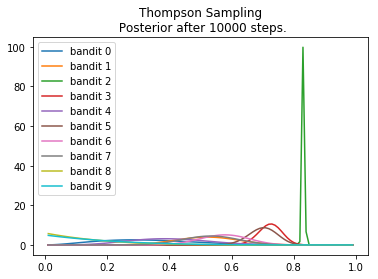

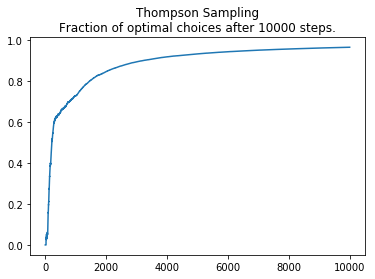

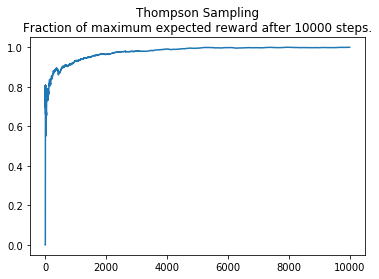

In [19]:
ps = uniform(0, 1, size=10)

sim = Simulation(BinomialThompsonSampling(), ps)
sim.run(10000)
sim.plot_all_results()

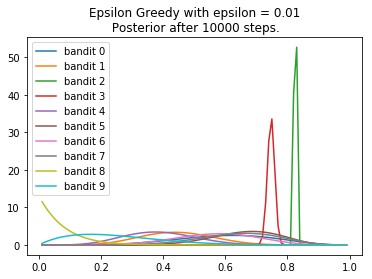

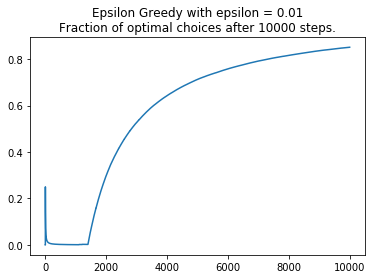

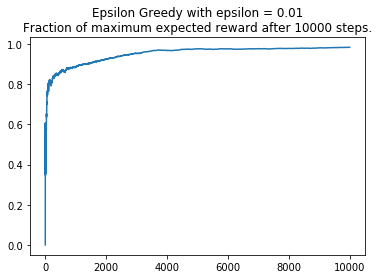

In [20]:
sim = Simulation(BinomialEpsilonGreedy(epsilon=0.01), ps)
sim.run(10000)
sim.plot_all_results()

## Running Many Simulations
If we run many simulations over a longer period of time, two things become apparent:
* Thompson sampling outperforms the epsilon-greedy methods in the long run. I believe there are two reasons for that
 * $\epsilon$-greedy with low $\epsilon$ is much more susceptible to getting stuck with good but not optimal bandits.
 * $\epsilon$-greedy with high $\epsilon$ necessarily samples suboptimal bandits more often.
* Thompson-sampling takes a few hundred iterations to outperform the $\epsilon$-greedy algorithms rewards. This makes intuitive sense because $\epsilon$-greedy methods will just stick with bandits that yield good results. This means that in the beginning, Thompson Sampling invest some time into getting good estimates before rejecting bad bandits. During this time, $\epsilon$-greedy's usage of good but suboptimal bandits will yeild more rewards.

This shows how solving the exploration vs. exploitation challenge with a rigorous, probabilistic approach is superior to more hand-waving heuristics in cases where it is feasible to do so. In other words, it pays off to not just compute a point estimate, but a distribution over your beliefs, and take this uncertainty into account for your actions.

In [95]:
def simulate_many(algorithm, params, simulations=10, steps=1000):
    optimal_fractions = []
    reward_fractions = []
    for i in range(simulations):
        sim = Simulation(algorithm(**params), ps)
        sim.run(steps)
        optimal_fractions.append(sim.fraction_of_optimal_choices())
        reward_fractions.append(sim.fraction_of_max_expected_reward())
        print(".", end="")
    print()
    mean_optimal_fractions = sps.mstats.gmean(np.clip(optimal_fractions, 1e-5, None), axis=0)    
    mean_rewards = sps.mstats.gmean(np.clip(reward_fractions, 1e-5, None), axis=0)
    return mean_optimal_fractions, mean_rewards

def simulate_all(algorithms, params, simulations=10, steps=1000):
    optimal_fractions = pd.DataFrame()    
    rewards = pd.DataFrame()
    for algorithm, params in zip(algorithms, params):
        algorithm_name = str(algorithm(**params))
        mean_optimal_fractions, mean_rewards = simulate_many(algorithm, params, simulations=simulations, steps=steps)
        optimal_fractions[algorithm_name] = pd.Series(mean_optimal_fractions)
        rewards[algorithm_name] = pd.Series(mean_rewards)
    return optimal_fractions, rewards



....................................................................................................
....................................................................................................
....................................................................................................


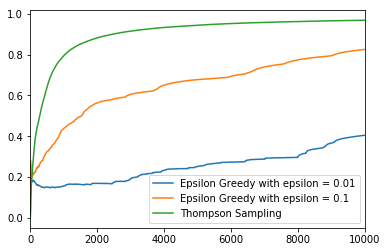

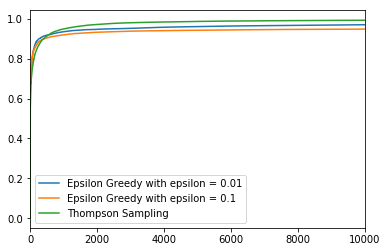

In [96]:
optimal_fractions, rewards = simulate_all(
    [BinomialEpsilonGreedy, BinomialEpsilonGreedy, BinomialThompsonSampling], [{"epsilon":0.01}, {"epsilon":0.1}, {}],
    steps=10000,
    simulations=100)
optimal_fractions.plot()
rewards.plot()

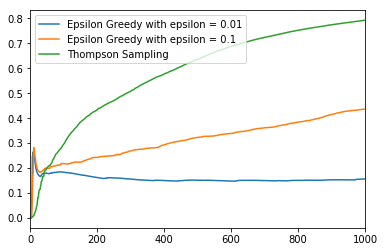

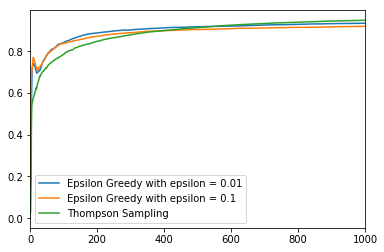

In [98]:
# Zoom in on the earlier runs
optimal_fractions.iloc[:1000].plot()
rewards.iloc[:1000].plot()